<a href="https://colab.research.google.com/github/antonvandike/Algoritmos-Geneticos/blob/main/Programacion%20Gen%C3%A9tica/regresion_simbolica_primer_intento.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

#Solucion del problema del control de paridad uniforme


In [1]:
pip install deap

###Configuraciones y definiciones

In [2]:
## Paso 1: Modulos

from deap import base
from deap import creator
from deap import tools
from deap import gp
from deap import algorithms

import random as rd
import numpy as np
import math as mt

import operator as op
import sympy as sp

import matplotlib.pyplot as plt
import seaborn as sns

import itertools
import matplotlib.pyplot as plt
import networkx as nx

from functools import partial


In [3]:
class txtParser:
    def __init__(self, txt):
        #Constructor
        self.x = []
        self.y = []
        self.populateList(txt)

    def populateList(self, file):
        with open(file) as fp:
            cnt = 0
            for line in fp:
                if(cnt<2):
                    cnt+=1
                    continue
                line = line.split()
                self.x.append(float(line[0]))
                self.y.append(float(line[1]))
        return #se puede comentar.

In [4]:
data = txtParser("regression_2.txt")

In [5]:
## Paso 2: Parametros del problema

# Contenido del problema

POPULATION_SIZE = 300    # Tamaño de la poblacion de individuos
P_CROSSOVER     =  0.5    # Probabilidad de cruza
P_MUTATION      =  0.1    # Probabilidad de mutación

MAX_GENERATIONS = 40   # Maximo numero de generaciones (condición de termino)

In [6]:
HALL_OF_FAME_SIZE = 1

In [7]:
# Constantes especificas de la progrmacion genetica:
MIN_TREE_HEIGHT = 1
MAX_TREE_HEIGHT = 3
LIMIT_TREE_HEIGHT = 17
MUT_MIN_TREE_HEIGHT = 0
MUT_MAX_TREE_HEIGHT = 2

In [8]:
## Paso 3: Elementos aleatorios

RANDOM_SEED = 42          # Comunmente cuando se experimenta con un codigo
rd.seed(RANDOM_SEED)      # se corre el problema con los mismos parametros
                          # para repetir y compara resultados

In [9]:
toolbox = base.Toolbox()

In [10]:
# Define new functions
def protectedDiv(left, right):
    try:
        return left / right
    except ZeroDivisionError:
        return 1

In [26]:
## Paso 4: Declarando el cromosoma

# create the primitive set:
pset = gp.PrimitiveSet("main", 1)

pset.addPrimitive(op.sub, 2)
pset.addPrimitive(op.mul, 2)
pset.addPrimitive(op.add, 2)
pset.addPrimitive(protectedDiv, 2)

# add terminal values:

pset.addEphemeralConstant("rand", lambda: rd.randint(-1,1))
pset.renameArguments(ARG0='x')

toolbox.register("expr", gp.genHalfAndHalf, pset=pset, min_=MIN_TREE_HEIGHT, max_=MAX_TREE_HEIGHT)

In [12]:
## Paso 5: Crear la funcion de aptitud (FITNESS)

# Se indica minimizacion y un solo peso
#creator.create("FitnessMin", base.Fitness, weights=(-1.0,))
#creator.create("FitnessMin", base.Fitness, weights=(-10.0,))
creator.create("FitnessMin", base.Fitness, weights=(-1.0,-0.8,-0.5))


In [13]:
## Paso 6: Crear la funcion de  aptitud del individuo

creator.create("Individual", gp.PrimitiveTree, fitness=creator.FitnessMin)

In [14]:
## Paso 7: Declarar el operador para generador de individuos

toolbox.register("individualCreator", tools.initIterate, creator.Individual, toolbox.expr)

{0: Text(-7.121559305792643e-05, 3.345072492430646e-05, 'add'),
 1: Text(1.0, -0.4697141972943188, 'x'),
 2: Text(-0.9999287844069418, 0.46968074656939446, 'x')}

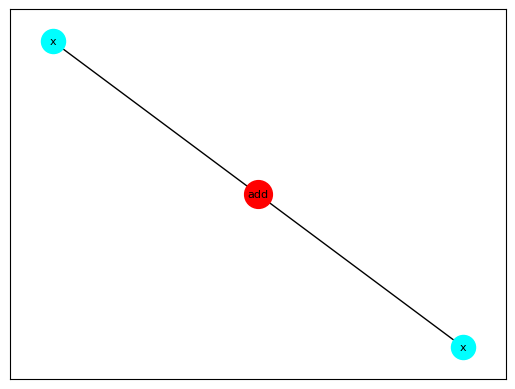

In [15]:
a = toolbox.individualCreator()
nodes, edges, labels = gp.graph(a)
g = nx.Graph()
g.add_nodes_from(nodes)
g.add_edges_from(edges)
pos = nx.spring_layout(g)

nx.draw_networkx_nodes(g, pos, node_color='cyan')
nx.draw_networkx_nodes(g, pos, nodelist=[0], node_color='red', node_size=400)

nx.draw_networkx_edges(g, pos)
nx.draw_networkx_labels(g, pos, **{"labels": labels, "font_size": 8})



In [16]:
## Paso 8: Declarar el operador para generar la poblacion

toolbox.register("populationCreator", tools.initRepeat, list, toolbox.individualCreator)

In [17]:
# Crear un operador para compilar el arbol primitivo en el codigo de python

toolbox.register("compile", gp.compile, pset=pset)

In [18]:
x  = [0,1,2,3,4,5,6,7,8,9]
y1 = [0.0,1.0,4.0,9.0,16.0,25.0,36.0,49.0,64.0,81.0]

In [19]:
## Paso 9: Definir función para calcular la aptitud


def symbolicRegression(individual, points, true):
    func = toolbox.compile(expr = individual)
    sqerrors = ((func(i)-j)**2 for i, j in zip(points, true))

    a = len(individual)
    b = individual.height

    return mt.fsum(sqerrors) / len(x), a, b,

In [20]:
symbolicRegression(toolbox.individualCreator(), data.x,data.y)

(103.072, 11, 3)

In [21]:
## Paso 10: Declarar el operador de evaluacion
toolbox.register("evaluate",symbolicRegression,points = data.x, true = data.y)


In [22]:
## Paso 11: Declarar los operadores geneticos

toolbox.register("select", tools.selTournament, tournsize=3)
toolbox.register("mate", gp.cxOnePoint)
toolbox.register("expr_mut", gp.genFull, min_=0, max_=2)
toolbox.register("mutate", gp.mutUniform, expr=toolbox.expr_mut, pset=pset)

In [23]:
# bloat control:


toolbox.decorate("mate", gp.staticLimit(key=op.attrgetter("height"), max_value=17))
toolbox.decorate("mutate", gp.staticLimit(key=op.attrgetter("height"), max_value=17))

In [24]:
def symbreg():

    pop = toolbox.populationCreator(POPULATION_SIZE)
    hof = tools.HallOfFame(HALL_OF_FAME_SIZE)

    stats_fit = tools.Statistics(lambda ind: ind.fitness.values)
    stats_size = tools.Statistics(len)

    mstats = tools.MultiStatistics(fitness=stats_fit, size=stats_size)
    mstats.register("avg", np.mean)
    mstats.register("std", np.std)
    mstats.register("min", np.min)
    mstats.register("max", np.max)

    pop, log = algorithms.eaSimple(pop,
                                   toolbox,
                                   cxpb=P_CROSSOVER,
                                   mutpb=P_MUTATION,
                                   ngen=MAX_GENERATIONS,
                                   stats=mstats,
                                   halloffame=hof,
                                   verbose=True)
    # print log
    best = hof.items[0]

    print("-- length={}, height={}".format(len(best), best.height))
    print("-- Best Fitness = ", best.fitness.values[0])


    # plot best tree:
    nodes, edges, labels = gp.graph(best)
    g = nx.Graph()
    g.add_nodes_from(nodes)
    g.add_edges_from(edges)
    pos = nx.spring_layout(g)

    nx.draw_networkx_nodes(g, pos, node_color='cyan')
    nx.draw_networkx_nodes(g, pos, nodelist=[0], node_color='red', node_size=400)

    nx.draw_networkx_edges(g, pos)
    nx.draw_networkx_labels(g, pos, **{"labels": labels, "font_size": 8})
    plt.show()

    print("-- Best Individual = ", best)

    tree = gp.PrimitiveTree(best)

    bestSym = toolbox.compile(expr = best)
    x2 = sp.Symbol('x')
    print(bestSym(x2))

    listres = []

    for i in range(len(data.x)):
        listres.append("x: %2f" % data.x[i])
        listres.append("y: %2f" % bestSym(data.x[i]))
    i=0
    j=0
    SSE = 0.0
    while i < len(listres):
        print("%s %s    Actual: %2f     Square error: %2f" %(listres[i],listres[i+1],data.y[j],(bestSym(data.x[j])-data.y[j])**2))
        SSE+=(bestSym(data.x[j])-data.y[j])**2
        j=j+1
        i=i+2
    SSE/=len(data.x)
    print("Seed: %d, Fitness: %2f"%(RANDOM_SEED,SSE))

    print('Comparación grafica')

    plt.plot(data.x,data.y)
    plt.plot(data.x, [bestSym(i) for i in data.x])
    plt.legend(('Datos reales', 'Datos aproximados'),
            prop = {'size': 10}, loc='upper right')
    plt.show()


   	      	                    fitness                    	                      size                     
   	      	-----------------------------------------------	-----------------------------------------------
gen	nevals	avg    	gen	max    	min	nevals	std    	avg    	gen	max	min	nevals	std    
0  	300   	215.768	0  	94193.2	1  	300   	3189.28	7.33333	0  	15 	3  	300   	4.69846
1  	162   	15.0941	1  	1683.27	1  	162   	60.7424	6.81333	1  	21 	3  	162   	4.68954
2  	181   	14.5569	2  	1554.71	0  	181   	72.2453	6.52   	2  	23 	1  	181   	4.18365
3  	169   	12.8462	3  	1216.61	0  	169   	42.9969	6.84   	3  	21 	1  	169   	3.8368 
4  	174   	17.1325	4  	1849.53	0  	174   	106.052	7.07333	4  	19 	1  	174   	3.8168 
5  	176   	12.497 	5  	1441.99	0  	176   	50.1767	7.18   	5  	21 	1  	176   	3.57877
6  	175   	14.7245	6  	2659.19	0  	175   	93.7343	7.88667	6  	21 	1  	175   	3.82977
7  	171   	12.9594	7  	1907.25	0  	171   	65.1413	8.20667	7  	21 	1  	171   	3.8881 
8  	169   	170.711	8 

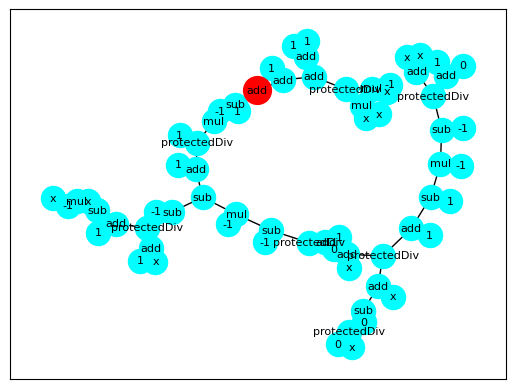

-- Best Individual =  add(add(add(protectedDiv(mul(x, x), mul(-1, x)), add(1, 1)), 1), sub(1, mul(protectedDiv(add(1, sub(sub(protectedDiv(add(1, sub(x, mul(x, -1))), add(x, 1)), -1), mul(sub(protectedDiv(add(1, 0), add(x, protectedDiv(add(1, sub(1, mul(sub(protectedDiv(add(1, 0), add(x, x)), -1), -1))), add(sub(protectedDiv(0, x), 0), x)))), -1), -1))), 1), -1)))
-x + 7 + 1/(x + (3 + 1/(2*x))/x) + (2*x + 1)/(x + 1)
x: 0.000000 y: 9.250000    Actual: 9.200000     Square error: 0.002500
x: 1.000000 y: 7.722222    Actual: 7.000000     Square error: 0.521605
x: 2.000000 y: 6.942529    Actual: 7.300000     Square error: 0.127786
x: 3.000000 y: 5.996575    Actual: 6.800000     Square error: 0.645491
x: 4.000000 y: 5.009150    Actual: 4.900000     Square error: 0.011914
x: 5.000000 y: 4.011269    Actual: 3.900000     Square error: 0.012381
x: 6.000000 y: 3.010661    Actual: 3.800000     Square error: 0.623056
x: 7.000000 y: 2.009431    Actual: 2.400000     Square error: 0.152544
x: 8.000000 

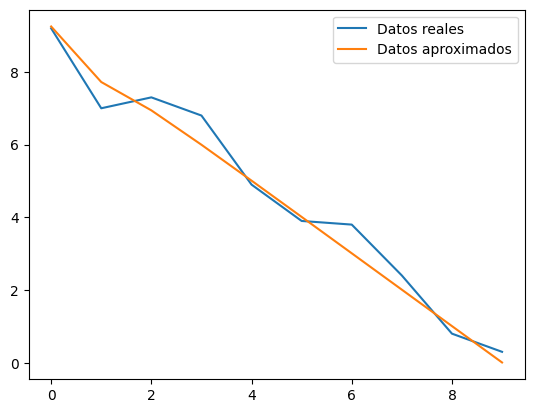

In [25]:
symbreg()